In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from optuna.integration import TFKerasPruningCallback
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [3]:
def load_data(data_path):
    data = pd.read_csv(data_path)
    X = data.iloc[:, 2:].to_numpy()
    Y = data["MFS_cens"].to_numpy()

    X = X.reshape(X.shape[0], X.shape[1], 1)
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = load_data("../../data/labels_features.csv")

In [4]:
checkpoint = ModelCheckpoint(
    filepath="../../models/optimizers/learning_best_trial.h5",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    mode="max",
)


def create_model(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)

    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-2, log=True)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])
    add_dense_before = trial.suggest_categorical("add_dense_before", [True, False])
    add_dense_after = trial.suggest_categorical("add_dense_after", [True, False])

    if add_dense_before:
        dense_units_before = trial.suggest_int("dense_units_before", 16, 64)

    if add_dense_after:
        dense_units_after = trial.suggest_int("dense_units_after", 16, 64)

    normalizer = layers.Normalization()
    normalizer.adapt(x_train)

    model = models.Sequential()
    model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
    model.add(normalizer)

    if add_dense_before:
        model.add(layers.Dense(dense_units_before, activation="relu"))

    if use_batch_norm:
        model.add(layers.BatchNormalization())

    model.add(
        layers.LSTM(
            lstm_units,
            activation="tanh",
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg),
        )
    )
    model.add(layers.Dropout(dropout_rate))

    if add_dense_after:
        model.add(layers.Dense(dense_units_after, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


def objective(trial):
    model = create_model(trial)

    history = model.fit(
        x_train,
        y_train,
        epochs=80,
        batch_size=64,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, TFKerasPruningCallback(trial, "val_accuracy")],
        verbose=0,
    )

    val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
    return val_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=80)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)


best_trial = study.best_trial
model = create_model(best_trial)
history = model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=3,
)

[I 2024-06-17 20:59:44,609] A new study created in memory with name: no-name-43ea0c82-303b-430c-b4bc-3c134a218a45
C:\Users\maksk\AppData\Local\Temp\ipykernel_18276\2272857142.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2024-06-17 20:59:56,266] Trial 0 finished with value: 0.7407407164573669 and parameters: {'lstm_units': 82, 'dropout_rate': 0.20874067194010243, 'l1_reg': 0.0008074888076327162, 'l2_reg': 6.957853691778922e-05, 'learning_rate': 0.002123943600334967, 'use_batch_norm': False, 'add_dense_before': False, 'add_dense_after': False}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-06-17 21:00:09,666] Trial 1 finished with value: 0.7407407164573669 and parameters: {'lstm_units': 57, 'dropout_rate': 0.3401330962312503, 'l1_reg': 0.00

Number of finished trials: 80
Best trial: {'lstm_units': 82, 'dropout_rate': 0.20874067194010243, 'l1_reg': 0.0008074888076327162, 'l2_reg': 6.957853691778922e-05, 'learning_rate': 0.002123943600334967, 'use_batch_norm': False, 'add_dense_before': False, 'add_dense_after': False}
Epoch 1/80
Epoch 2/80
Epoch 3/80
Epoch 4/80
Epoch 5/80
Epoch 6/80
Epoch 7/80
Epoch 8/80
Epoch 9/80
Epoch 10/80
Epoch 11/80
Epoch 12/80
Epoch 13/80
Epoch 14/80
Epoch 15/80
Epoch 16/80
Epoch 17/80
Epoch 18/80
Epoch 19/80
Epoch 20/80
Epoch 21/80
Epoch 22/80
Epoch 23/80
Epoch 24/80
Epoch 25/80
Epoch 26/80
Epoch 27/80
Epoch 28/80
Epoch 29/80
Epoch 30/80
Epoch 31/80
Epoch 32/80
Epoch 33/80
Epoch 34/80
Epoch 35/80
Epoch 36/80
Epoch 37/80
Epoch 38/80
Epoch 39/80
Epoch 40/80
Epoch 41/80
Epoch 42/80
Epoch 43/80
Epoch 44/80
Epoch 45/80
Epoch 46/80
Epoch 47/80
Epoch 48/80
Epoch 49/80
Epoch 50/80
Epoch 51/80
Epoch 52/80
Epoch 53/80
Epoch 54/80
Epoch 55/80
Epoch 56/80
Epoch 57/80
Epoch 58/80
Epoch 59/80
Epoch 60/80
Epoch 61

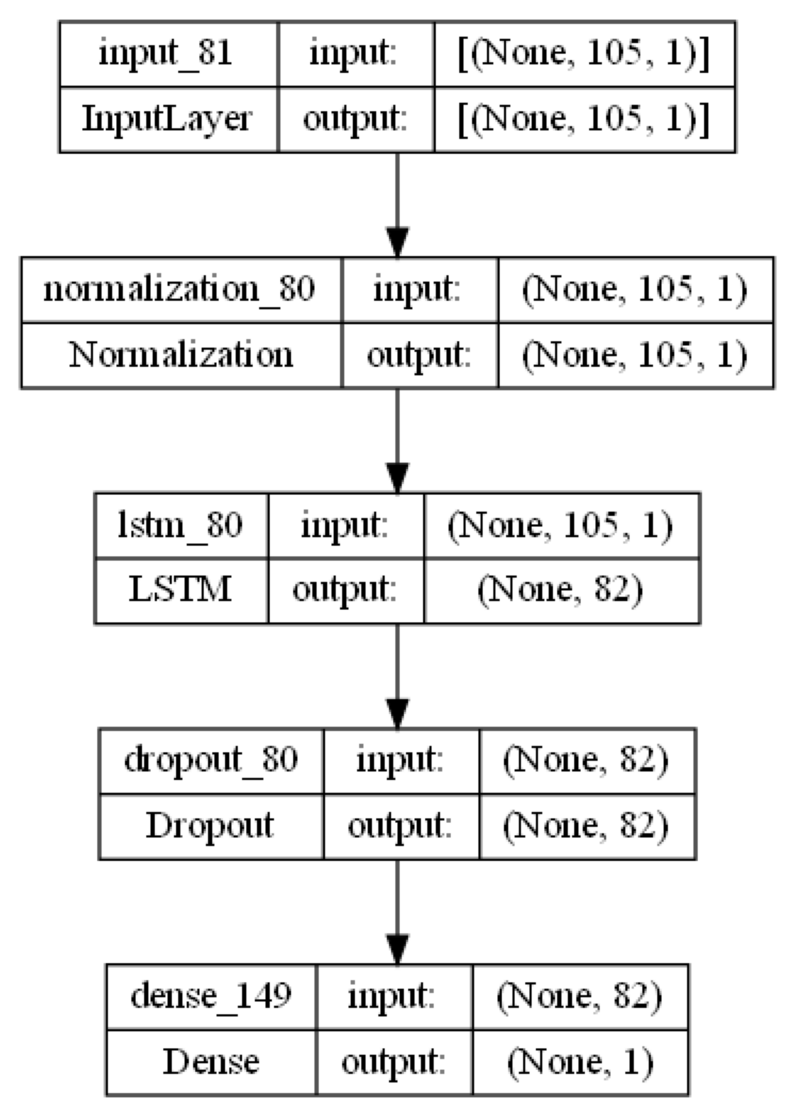

In [5]:
model.save("../../models/optimizers/learning_best_model.h5")

# Plot model architecture
plot_file = "../../models/optimizers/learning_model.png"
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the model plot
plt.figure(figsize=(10, 15))
img = plt.imread(plot_file)
plt.imshow(img)
plt.axis("off")
plt.show()